<h1>Second try with ADAM, 1129_2</h1>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build
%load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

import shutil
import gc
import time
import datetime
import random
from winsound import Beep
from PIL import Image
import pickle
def beep():
    Beep(1000, 100)
    
beep()
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12,8]

In [5]:
addr = r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env"
os.chdir(addr)

<h1>load super-expanded training data</h1>

In [6]:
with open('f_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
beep()

<h1>sample training data</h1>

In [7]:
# sample training data
n = len(train_x)
sn = int(n / 10)
np.random.seed(42)
index = np.random.choice([i for i in range(n)], size=sn, replace=False)

sub_tx, sub_ty = [], []

for ind in index:
    sub_tx.append(train_x[ind])
    sub_ty.append(train_y[ind])

sub_tx = np.array(sub_tx)
sub_ty = np.array(sub_ty)
sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

beep()

gc.collect()

0

<h1>Useful functions:</h1>

In [9]:
# def plot_decay(init_val, rate, nep):
#     dec_list = []
#     val = init_val
#     rate = rate
#     for i in range(nep):
#         dec_list.append(val)
#         val = rate * val

#     plt.plot(dec_list)
#     plt.axhline(min(dec_list))
#     plt.show()
#     print('init eta:', init_val)
#     print('min eta:', min(dec_list))
#     print('#' * 50)

# Beep(1000, 100)

<h1>Build Network models</h1>

<h2>garbage collect</h2>

In [8]:
gc.collect()

0

<h2>betch size = 1000 seems to be a good balancing point between accuracy and computation time.</h2>

<h4>Before going to step 2, I want to test out Tensorboard:</h4>

In [9]:
# def full_summary(layer):
#     #check if this layer has layers
#     if hasattr(layer, 'layers'):
#         print('summary for ' + layer.name)
#         layer.summary()
#         print('\n\n')
#         for l in layer.layers:
#             full_summary(l)

def build_adam_model(
    lmbda,
    n_eph,
    batch_size,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
    ):
    #############################################################
    tf.random.set_seed(42)
    #############################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('learning_rate= {}\n'.format(learning_rate))
    print('beta_1= {}\n'.format(beta_1))
    print('beta_2= {}\n'.format(beta_2))
    print('epsilon= {}\n'.format(epsilon))
    #############################################################
    
    model = tf.keras.models.Sequential()

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            ),
            input_shape=input_shape
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(2,2),
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Flatten()
    )

    model.add(
        tf.keras.layers.Dense(
            1000,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.Dense(
            10,
            activation=out_activation
        )
    )

    ################################################################
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
        amsgrad=amsgrad,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    return model
    
Beep(1000,100)


In [10]:
def train_cnn_adam_tensorboardCB( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x, train_y,
        val_x, val_y,
        test_x, test_y,
        addr,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        input_shape=(28, 28, 1),
        hidden_activation=tf.nn.relu,
        out_activation=tf.nn.softmax,
        load_model_path=None
    ):
    
    ################################################################
    #  set time stamp:
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    ################################################################
    #  set checkpointCB
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    ################################################################
    #  set tensorboardCB
    log_dir = "logs/fit/" + stamp
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    if load_model_path is not None:
        model = tf.keras.models.load_model(load_model_path) 

    else:
        ################################################################
        # build model
        model = build_adam_model(
            lmbda,
            n_eph,
            batch_size,
            learning_rate = learning_rate,
            beta_1 = beta_1,
            beta_2 = beta_2,
            epsilon = epsilon,
            amsgrad = amsgrad,
            input_shape = input_shape,
            hidden_activation = hidden_activation,
            out_activation = out_activation
        )        
        
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback, tensorboard_callback],
        shuffle=True
    )
    te = time.time()
    ################################################################

    
    ################################################################
    # summarize time and history
    print('total time:', te - ts)
    acc = history.history['accuracy']; print('\nacc', acc)
    loss = history.history['loss']; print('\nloss', loss)
    val_acc = history.history['val_accuracy']; print('\nval_acc', val_acc)
    val_loss = history.history['val_loss']; print('\nval_loss', val_loss)
    print()
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    model.load_weights(checkpoint_filepath).expect_partial()
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    
    ################################################################
    ################################################################
    #    visualize result
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    gc.collect()
    Beep(1000, 100)
    print('log_dir:', log_dir)
    
    
    
    return log_dir

Beep(1000,100)
%reload_ext tensorboard

<h1><h1/>
<h1>2. Train the model to 40 epochs and play with learning_rate</h1>

In [14]:
# ###########################################
# ## delete all tensorboard logs:

# p = './logs/'
# shutil.rmtree(p, ignore_errors=True)

<h3>quick test for TB</h3>

lmbda= 0.0001

n_eph= 5

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              289000    
___________

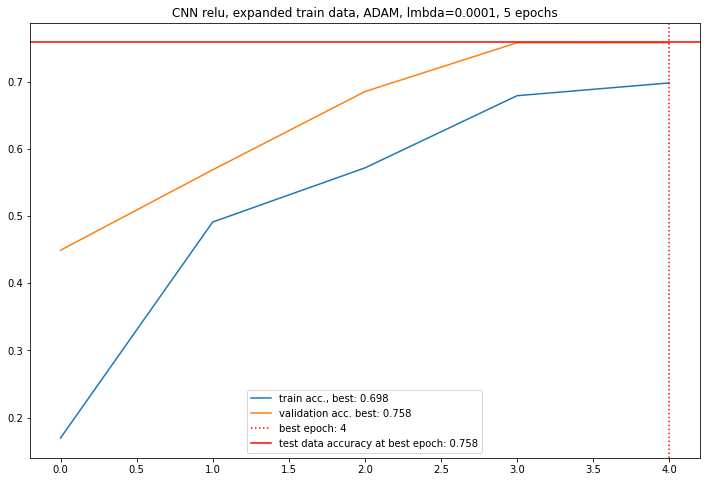

log_dir: logs/fit/20211129-144312


Reusing TensorBoard on port 6006 (pid 9776), started 0:24:09 ago. (Use '!kill 9776' to kill it.)

In [15]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 5


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x,
#     train_y,
    sub_tx[:2000],
    sub_ty[:2000],
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir_spec tb_path


<h3>Ok this is def. information overload. It might come handy later though.</h3>

<h1>Experiment:</h1>

<h4>default learning rate (0.001)</h4>

lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              289000    
__________

1/1 [==============================] - 0s 466ms/step - loss: 0.0417 - accuracy: 0.9936


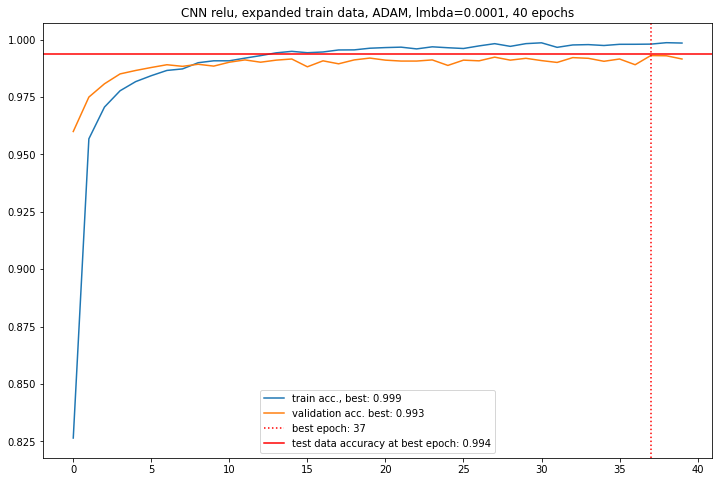

log_dir: logs/fit/20211129-144429


Reusing TensorBoard on port 6006 (pid 1096), started 1:08:03 ago. (Use '!kill 1096' to kill it.)

In [16]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


<h2>Now the default learning rate seems reasonable, I think part of the problem may be with batch size setting. Batch size and beta1/beta2 are related i.e.
changing batch size has the same effect as tuning beta1/beta2.
(https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear)</h2>
<h2>Also, from TB we can see that the dense layer's bias is not converging yet.</h2>
<h2>This may imply that we our learning rate is too fast, or more training is needed.</h2>
<h2>In this case, I think training for more epochs may get better result.</h2>


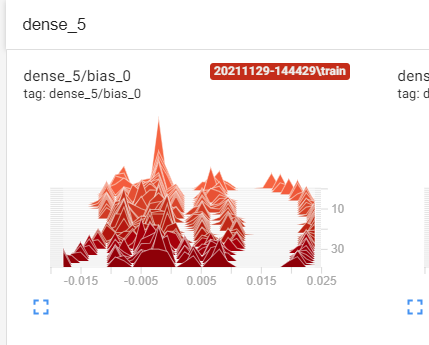

<h1>try a lower learning rate</h1>

lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.0001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              289000    
_________

1/1 [==============================] - 0s 461ms/step - loss: 0.0761 - accuracy: 0.9891


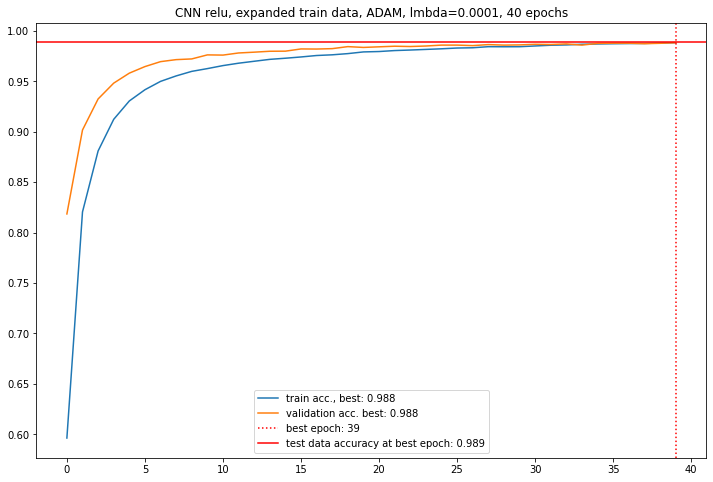

log_dir: logs/fit/20211129-150004


Reusing TensorBoard on port 6006 (pid 1096), started 1:23:20 ago. (Use '!kill 1096' to kill it.)

In [18]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
#     learning_rate=0.001,
    learning_rate=0.001 / 10,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


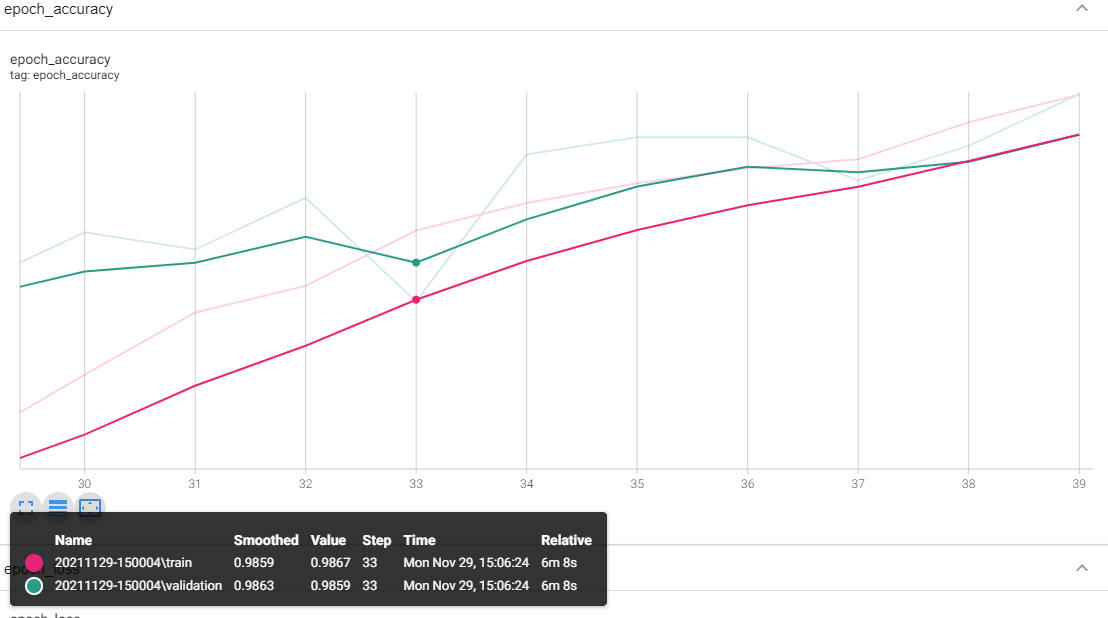

<h3>I think convergence is going to take a lot longer.</h3>
<h3>Calidation follows training acc. closely which implies we are not close to overtraining, yet.</h3>

<h1>try a higher learning rate</h1>

lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.01

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              289000    
___________

1/1 [==============================] - 1s 546ms/step - loss: 0.0655 - accuracy: 0.9891


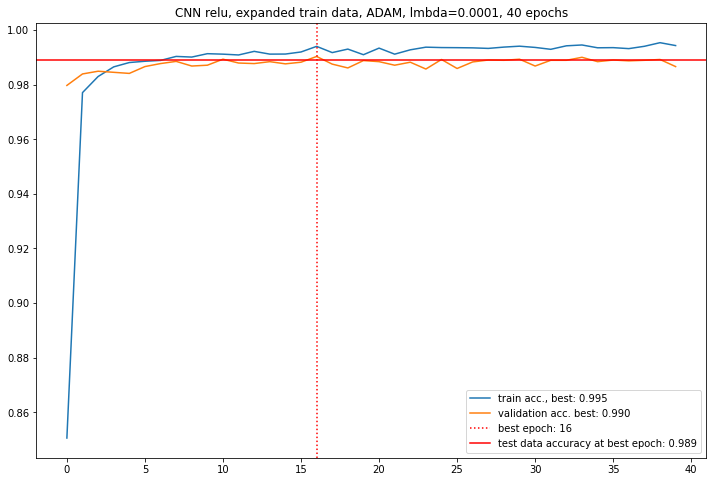

log_dir: logs/fit/20211129-151230


Reusing TensorBoard on port 6006 (pid 1096), started 1:35:32 ago. (Use '!kill 1096' to kill it.)

In [21]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
#     learning_rate=0.001,
    learning_rate=0.001 * 10,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


<h2>Clearly overshooting the target.</h2>

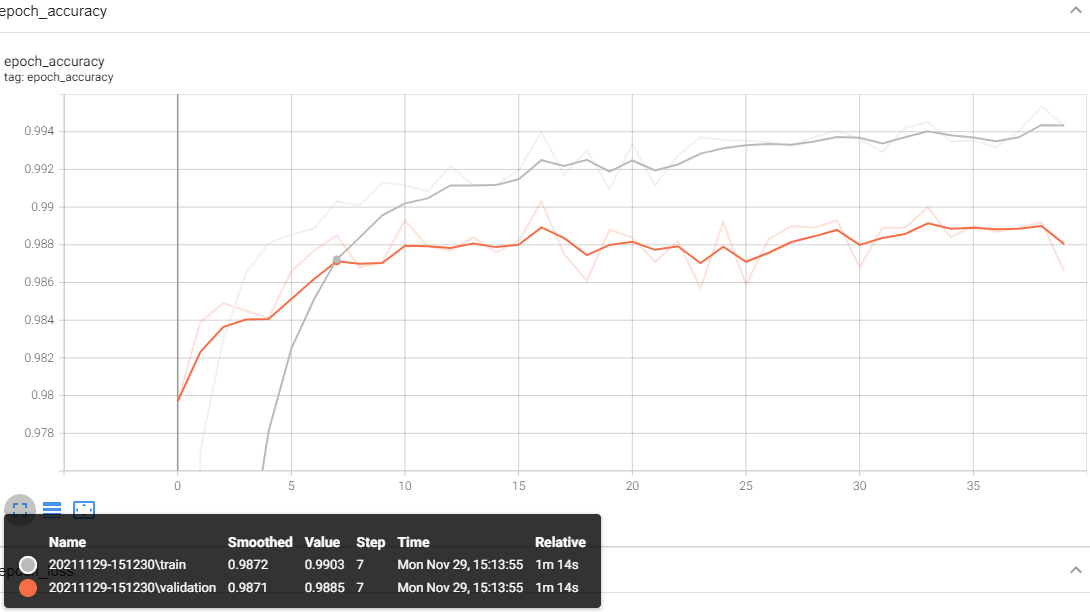

<h1>Next, I would like to train using default param using changed batch size for 88 epochs and see where it saturates.</h1>

lmbda= 0.0001

n_eph= 88

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              289000    
__________

75/75 [==============================] - 12s 159ms/step - loss: 0.0240 - accuracy: 0.9974 - val_loss: 0.0495 - val_accuracy: 0.9921
Epoch 48/88
75/75 [==============================] - 12s 160ms/step - loss: 0.0210 - accuracy: 0.9987 - val_loss: 0.0478 - val_accuracy: 0.9927
Epoch 49/88
75/75 [==============================] - 12s 158ms/step - loss: 0.0188 - accuracy: 0.9992 - val_loss: 0.0474 - val_accuracy: 0.9926
Epoch 50/88
75/75 [==============================] - 12s 159ms/step - loss: 0.0201 - accuracy: 0.9986 - val_loss: 0.0523 - val_accuracy: 0.9914
Epoch 51/88
75/75 [==============================] - 11s 151ms/step - loss: 0.0211 - accuracy: 0.9982 - val_loss: 0.0453 - val_accuracy: 0.9925
Epoch 52/88
75/75 [==============================] - 11s 151ms/step - loss: 0.0197 - accuracy: 0.9987 - val_loss: 0.0463 - val_accuracy: 0.9928
Epoch 53/88
75/75 [==============================] - 11s 151ms/step - loss: 0.0221 - accuracy: 0.9977 - val_loss: 0.0497 - val_accuracy: 0.9920
Epoc

1/1 [==============================] - 0s 445ms/step - loss: 0.0377 - accuracy: 0.9936


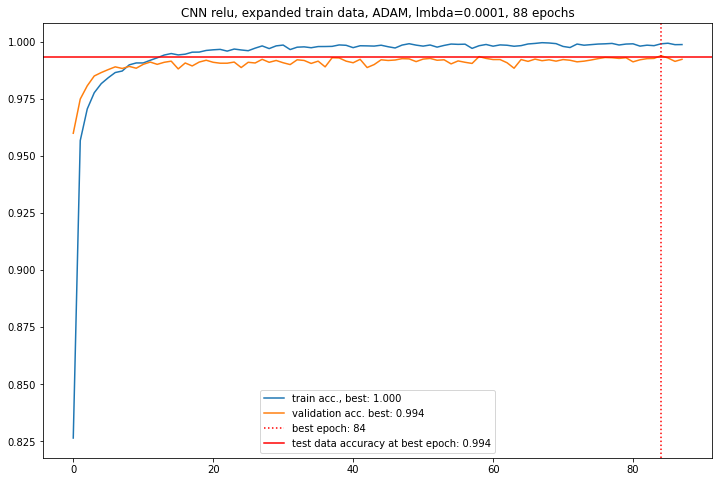

log_dir: logs/fit/20211129-152628


Reusing TensorBoard on port 6006 (pid 1096), started 1:59:48 ago. (Use '!kill 1096' to kill it.)

In [23]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 88


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


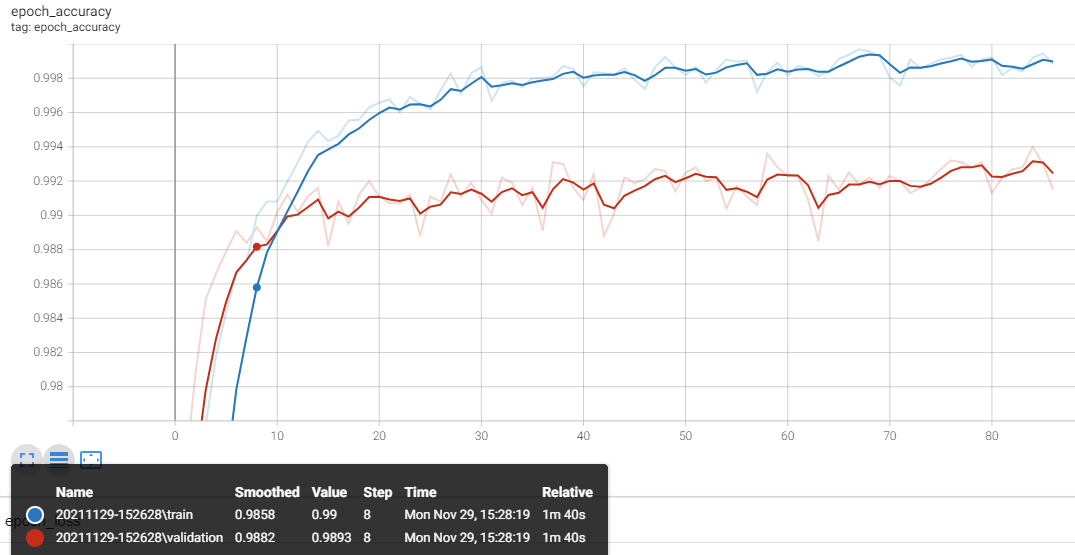

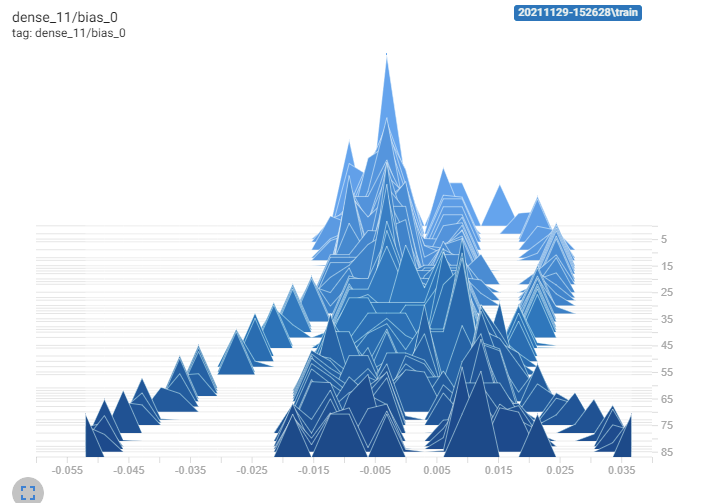

<h2>Both bias and val. acc is converging but not there are big jumps even near the end of training.</h2>
<h2>The learning rate may be too fast for 88 epochs.<h2/>

<h1>Try 50% default learning rate</h1>

lmbda= 0.0001

n_eph= 88

batch_size= 1000

learning_rate= 0.0005

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              289000    
_________

75/75 [==============================] - 11s 150ms/step - loss: 0.0285 - accuracy: 0.9981 - val_loss: 0.0650 - val_accuracy: 0.9887
Epoch 48/88
75/75 [==============================] - 11s 151ms/step - loss: 0.0301 - accuracy: 0.9973 - val_loss: 0.0638 - val_accuracy: 0.9906
Epoch 49/88
75/75 [==============================] - 11s 151ms/step - loss: 0.0281 - accuracy: 0.9980 - val_loss: 0.0532 - val_accuracy: 0.9920
Epoch 50/88
75/75 [==============================] - 11s 150ms/step - loss: 0.0268 - accuracy: 0.9984 - val_loss: 0.0562 - val_accuracy: 0.9916
Epoch 51/88
75/75 [==============================] - 11s 153ms/step - loss: 0.0257 - accuracy: 0.9986 - val_loss: 0.0531 - val_accuracy: 0.9912
Epoch 52/88
75/75 [==============================] - 11s 152ms/step - loss: 0.0266 - accuracy: 0.9982 - val_loss: 0.0515 - val_accuracy: 0.9928
Epoch 53/88
75/75 [==============================] - 13s 167ms/step - loss: 0.0250 - accuracy: 0.9987 - val_loss: 0.0561 - val_accuracy: 0.9919
Epoc

1/1 [==============================] - 0s 469ms/step - loss: 0.0393 - accuracy: 0.9933


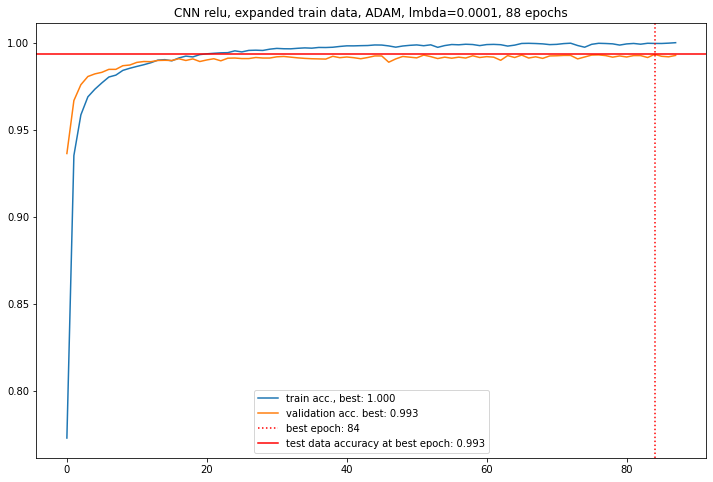

log_dir: logs/fit/20211129-155206


Reusing TensorBoard on port 6006 (pid 1096), started 2:24:24 ago. (Use '!kill 1096' to kill it.)

In [25]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 88


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001 * 0.5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


<h2>training accuracy just saturated but validation is not growing anymore.</h2>

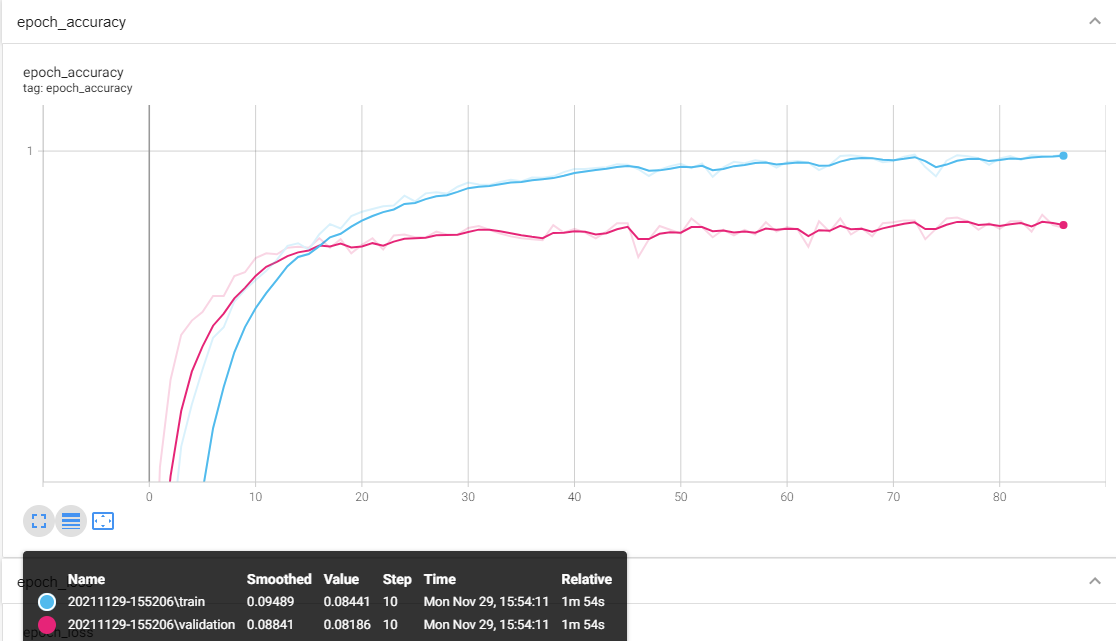

<h2>dense bias is still in searching mode</h2>

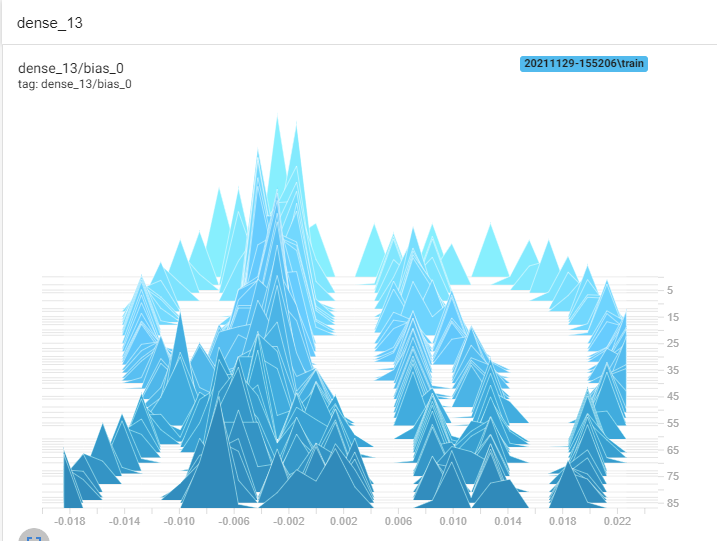

<h1>Since the best accuracy is obtained near the end of session, I will let it train more.</h1>

<h2>try the same settings with 128 epochs</h2>

<h4>I got a bug in my code that does not allow me to save the full model. need to retrain.</h4>
<h4>I need some help with setting up saving/loading model and optimizer state... I searched over the net but can't seem to fine a way for it to work correctly.</h4>

checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211129-172907
lmbda= 0.0001

n_eph= 128

batch_size= 1000

learning_rate= 0.0005

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 288)               0         
_____________________________________________

Epoch 33/128
75/75 [==============================] - 11s 149ms/step - loss: 0.0401 - accuracy: 0.9964 - val_loss: 0.0603 - val_accuracy: 0.9916
Epoch 34/128
75/75 [==============================] - 11s 144ms/step - loss: 0.0395 - accuracy: 0.9967 - val_loss: 0.0580 - val_accuracy: 0.9912
Epoch 35/128
75/75 [==============================] - 11s 151ms/step - loss: 0.0378 - accuracy: 0.9969 - val_loss: 0.0606 - val_accuracy: 0.9909
Epoch 36/128
75/75 [==============================] - 11s 147ms/step - loss: 0.0375 - accuracy: 0.9968 - val_loss: 0.0602 - val_accuracy: 0.9907
Epoch 37/128
75/75 [==============================] - 11s 150ms/step - loss: 0.0361 - accuracy: 0.9972 - val_loss: 0.0634 - val_accuracy: 0.9906
Epoch 38/128
75/75 [==============================] - 11s 148ms/step - loss: 0.0357 - accuracy: 0.9971 - val_loss: 0.0588 - val_accuracy: 0.9905
Epoch 39/128
75/75 [==============================] - 11s 146ms/step - loss: 0.0343 - accuracy: 0.9973 - val_loss: 0.0563 - val_ac

Epoch 86/128
75/75 [==============================] - 12s 157ms/step - loss: 0.0157 - accuracy: 0.9995 - val_loss: 0.0463 - val_accuracy: 0.9921
Epoch 87/128
75/75 [==============================] - 11s 149ms/step - loss: 0.0150 - accuracy: 0.9996 - val_loss: 0.0450 - val_accuracy: 0.9918
Epoch 88/128
75/75 [==============================] - 11s 146ms/step - loss: 0.0140 - accuracy: 0.9999 - val_loss: 0.0456 - val_accuracy: 0.9926
Epoch 89/128
75/75 [==============================] - 11s 150ms/step - loss: 0.0192 - accuracy: 0.9977 - val_loss: 0.0483 - val_accuracy: 0.9919
Epoch 90/128
75/75 [==============================] - 11s 146ms/step - loss: 0.0184 - accuracy: 0.9983 - val_loss: 0.0532 - val_accuracy: 0.9904
Epoch 91/128
75/75 [==============================] - 11s 146ms/step - loss: 0.0185 - accuracy: 0.9984 - val_loss: 0.0488 - val_accuracy: 0.9909
Epoch 92/128
75/75 [==============================] - 11s 146ms/step - loss: 0.0167 - accuracy: 0.9989 - val_loss: 0.0435 - val_ac

1/1 [==============================] - 1s 643ms/step - loss: 0.0349 - accuracy: 0.9934


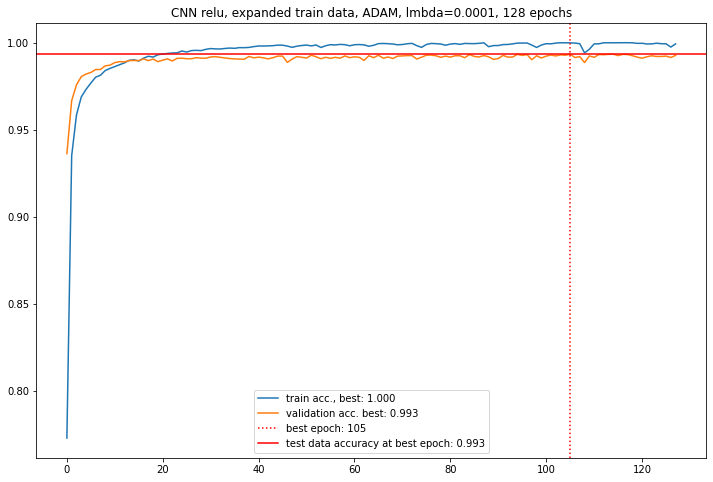

log_dir: logs/fit/20211129-172907


Reusing TensorBoard on port 6006 (pid 1096), started 4:09:44 ago. (Use '!kill 1096' to kill it.)

In [41]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 128


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001 * 0.5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


<h2>seems like loss is just about to hit tangent... may need to train a little longer?</h2>
<h2>regardless, these trainings are done with a small subset(10%) of the full training data.</h2>
<h2>it's time to go home, so I will do a long traning with full training data.</h2>

In [43]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 400 # 12hr


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
    train_x, train_y,
#     sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001 * 0.5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211129-180319
lmbda= 0.0001

n_eph= 128

batch_size= 1000

learning_rate= 0.0005

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 288)               0         
_____________________________________________

KeyboardInterrupt: 

In [44]:
12 * 3600 / 100


432.0

<h1>NEED HELP WITH THIS</h1>

In [38]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 128
learning_rate=5000.0
beta_1=0.9
beta_2=0.999
epsilon=1e-07
amsgrad=False
input_shape=(28, 28, 1)
hidden_activation=tf.nn.relu
out_activation=tf.nn.softmax






tx = train_x[:5000]
ty = train_y[:5000]



model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D( # no padding
        32,
        (5,5),
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        ),
        input_shape=input_shape
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Conv2D( # no padding
        32,
        (5,5),
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        )
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(
        1000,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        )
    )
)

model.add(
    tf.keras.layers.Dense(
        10,
        activation=out_activation
    )
)

################################################################
optimizer_adam = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
    amsgrad=amsgrad,
    name='Adam'
)
################################################################
# compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
################################################################
model.summary()


################################################################
#  set checkpointCB
stamp = 'test123'
checkpoint_filepath = addr + '\{}'.format(stamp)
print('checkpoint_filepath:',checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)




history = model.fit(
    tx, ty, 
    epochs=1,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=False
)



history = model.fit(
    tx, ty, 
    epochs=4,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
#     callbacks=[model_checkpoint_callback],
    shuffle=False
)














# #############################################################
# tf.random.set_seed(42)
# #############################################################

load_model_path = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\test123'

model = tf.keras.models.load_model(load_model_path) 

history = model.fit(
    tx, ty, 
    epochs=2,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=False
)






Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              289000    
_________________________________________________________________
dense_29 (Dense)             (None, 10)              